In [162]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [163]:
## read in the data
crime = pd.read_csv('Crime_Data_Chicago.csv',low_memory = False)
crime = crime[:5000]

In [164]:
## create latitude and longitude columns separately
crime['latitude'] = np.array([float(s.split(',')[0][1:]) for s in crime['Location ']])
crime['longitude'] = np.array([float(s.split(',')[1][:-1]) for s in crime['Location ']])

In [165]:
## rescale time variable
def newTimes(df):
    df['Time Occurred'][np.where(df['Time Occurred'] < 800)[0]] = 2400 - (800 - df['Time Occurred'][np.where(df['Time Occurred'] < 800)[0]])
    df['Time Occurred'][np.where(df['Time Occurred'] >= 800)[0]] = df['Time Occurred'][np.where(df['Time Occurred'] >= 800)[0]] - 800
    
## make sex binary!
def newSex(df):
    df['Sex'] = np.zeros(len(df['Victim Sex']))
    df['Sex'][np.where(df['Victim Sex'] == 'M')[0]] = 1
    df['Sex'][np.where(df['Victim Sex'] == 'F')[0]] = 0
    df['Sex'][np.where(df['Victim Sex'] == '')[0]] = 0

## clean age (remove missing values)
def cleanAge(df):
    meanAge = np.mean(df['Victim Age'])
    df['Victim Age'][np.isnan(df['Victim Age'])] = meanAge

## Normilze All Variables
def normalizeDF(df,columns):
    return (df[columns] - df[columns].mean()) / (np.absolute(df[columns]).max()) 

In [166]:
## distance formulas
def L2Norm(pt1,pt2):
    return np.sqrt(np.sum((pt1.values[0] - pt2.values[0]) ** 2))

def L1Norm(pt1,pt2):
    return np.sum(np.absolute((pt1.values[0] - pt2.values[0])))

In [167]:
def classifyPoint(point, centroids, clusters, distFunc):
    smallestDist = np.inf
    closestCentroid = 0
    
    for c in range(len(centroids)):
        #if (centroids.iloc[[c]].equals(point)):
        #    closestCentroid = c
        
        temp = distFunc(centroids.iloc[[c]], point)
        if temp < smallestDist:
            closestCentroid = c
            smallestDist = temp
            
    # Add point to closest cluster
    clusters[closestCentroid].append(point)

In [168]:
def getCentroids(df, centroids, clusters):
    newClusters = pd.DataFrame(data=None, columns=df.columns)
    for key, points in clusters.items():
        if points == []:
            newClusters = pd.concat([newClusters, centroids.iloc[[key]]], axis=0)
        else:
            cluster = pd.DataFrame(data=None, columns=df.columns)
            for p in points:
                cluster = pd.concat([cluster, pd.DataFrame(p)], axis=0)
            newClusters = newClusters.append(np.mean(cluster), ignore_index=True)
    
    return newClusters

In [169]:
def cluster(df,columns,k,distFunc):
    df = df[columns]
    
    ## pick k random points from the data set 
    ## and make sure they are unique
    firstIDs = np.random.randint(len(df), size = k)
    while (len(np.unique(firstIDs)) < k):
        firstIDs = np.random.randint(len(df), size = k)
    
    ## set centroids
    centroids = df.iloc[firstIDs]
    centroids.index = range(k)
    
    ## run until clusters don't change (hopefully not forever)
    while True:
        clusters = {k: [] for k in range(k)}
        for p in range(len(df)):
            point = df.iloc[[p]]
            classifyPoint(point, centroids, clusters, distFunc)
            
        newCentroids = getCentroids(df, centroids, clusters)
        
        # maybe check if it hits a certain threshold?
        if (centroids.equals(newCentroids)):
            break
        else:
            centroids = newCentroids
            
    return clusters

In [170]:
crimeCodes = crime[['Crime Code', 'Crime Code Description']]
crimeCodes['Crime Code'] = (crimeCodes['Crime Code'] - crimeCodes['Crime Code'].mean()) / (np.absolute(crimeCodes['Crime Code']).max())
#crimeCodesMap = {code: desc for code, desc in crimeCodes.itertuples(index=False)}
#crimeCodesMap

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [171]:
cols = ['Time Occurred','Area ID','Reporting District','Crime Code','Victim Age','Sex','Premise Code','latitude','longitude']

In [172]:
## data cleaning
newTimes(crime)
newSex(crime)
cleanAge(crime)


/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/lib/

In [173]:
means = {}
maxs = {}
for col in cols:
    means[col] = crime[col].mean()
    maxs[col] = np.absolute(crime[col].max())
crime = normalizeDF(crime, cols)

In [174]:
clusters = cluster(crime,cols,3, L2Norm)

In [175]:
niceDisplay = pd.DataFrame(data=None, columns=cols)
for cluster, points in clusters.items():
    for point in points:
        temp = pd.DataFrame(point)
        temp['Cluster'] = cluster
        niceDisplay = niceDisplay.append(temp, ignore_index=True)

In [176]:
for col in cols:
    niceDisplay[col] = ( niceDisplay[col] * maxs[col] ) + means[col]

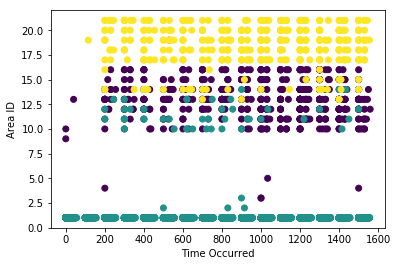

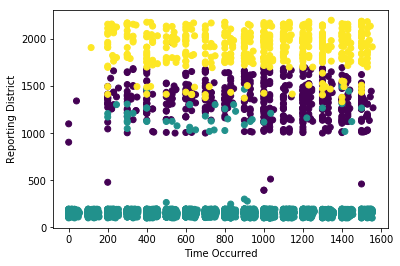

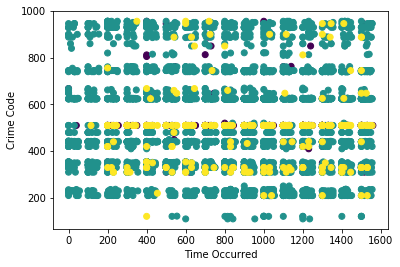

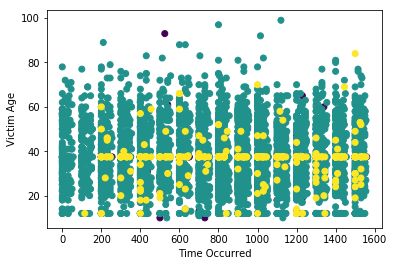

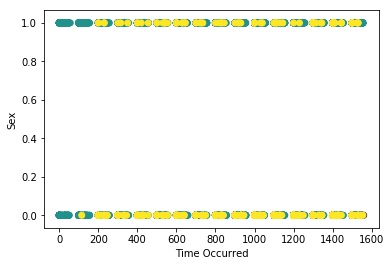

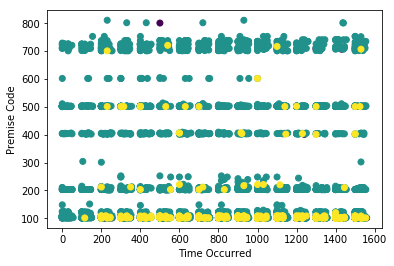

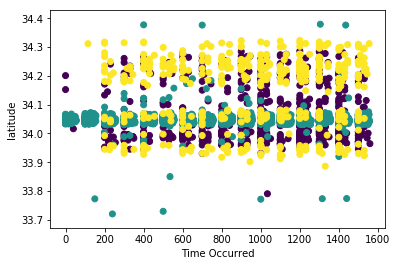

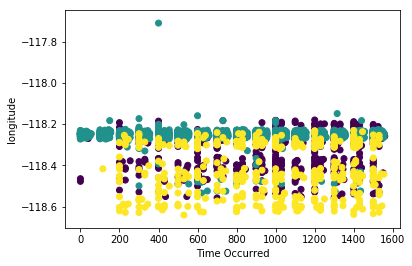

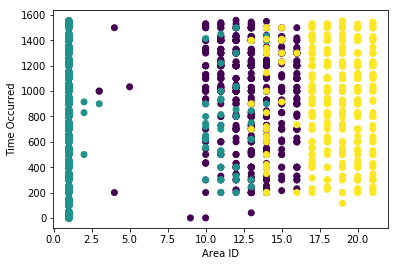

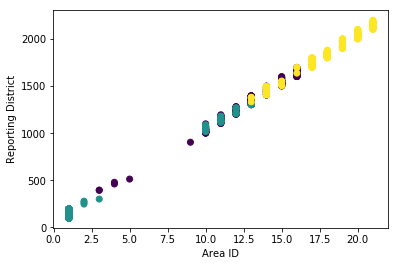

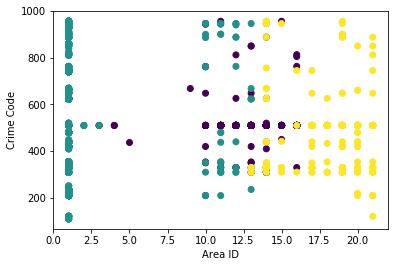

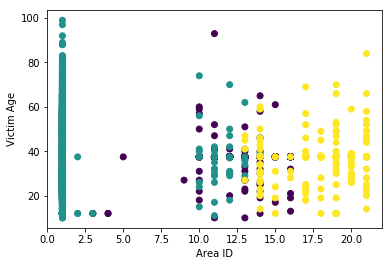

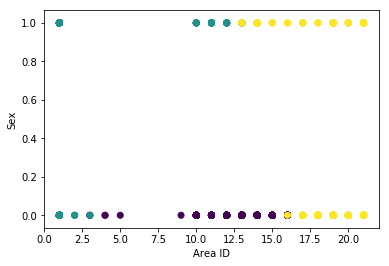

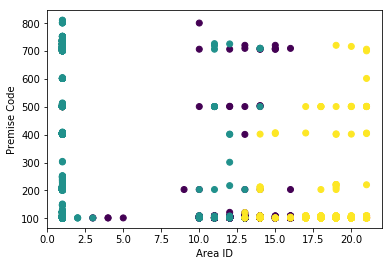

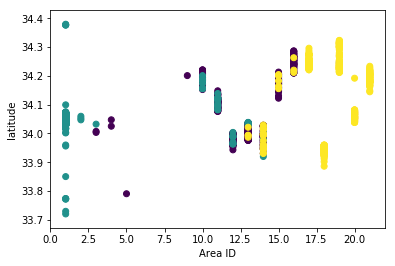

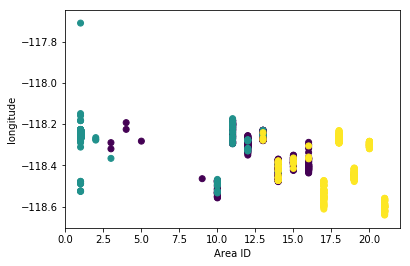

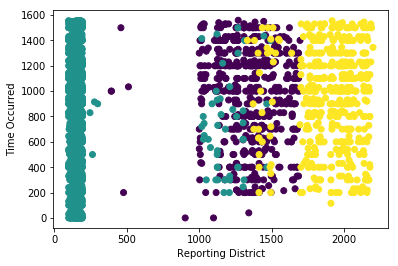

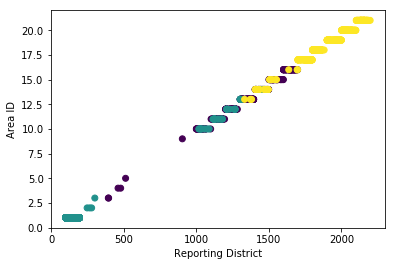

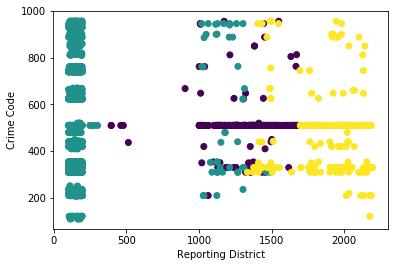

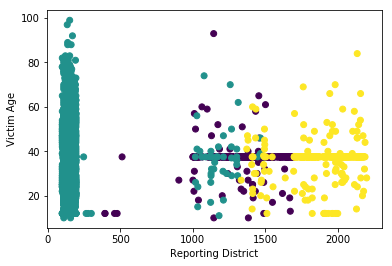

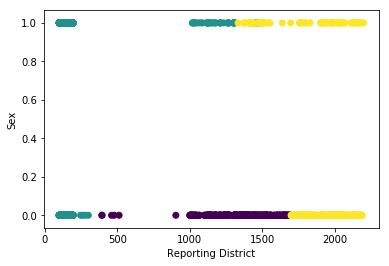

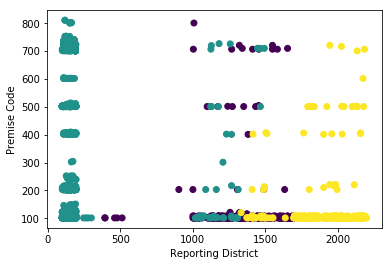

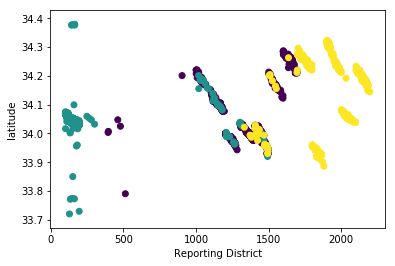

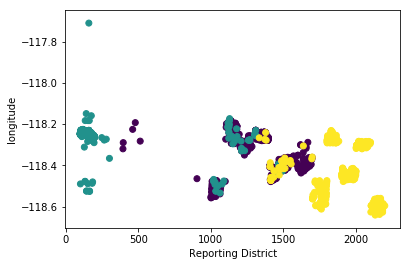

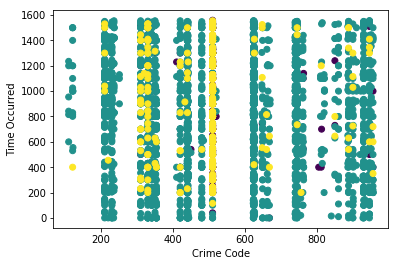

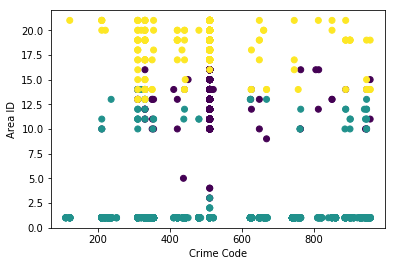

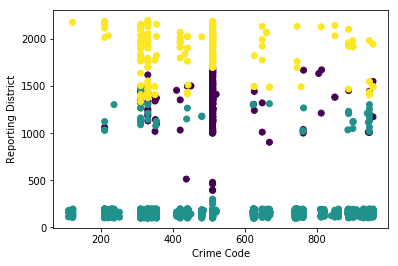

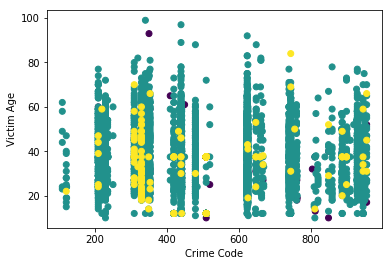

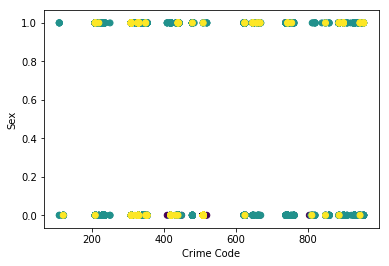

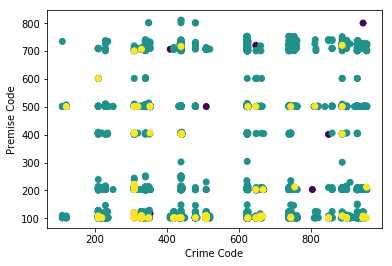

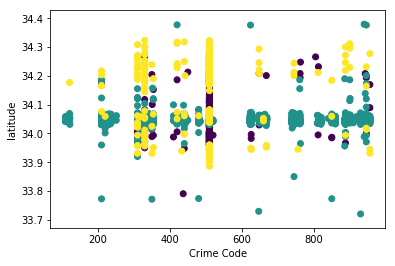

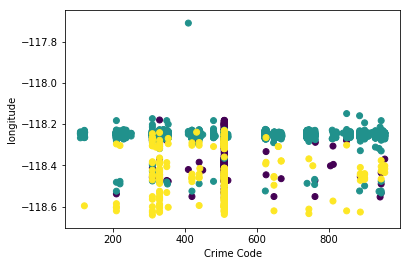

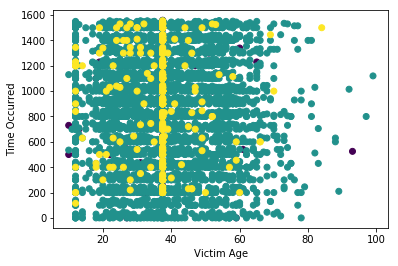

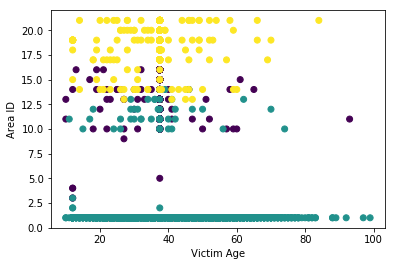

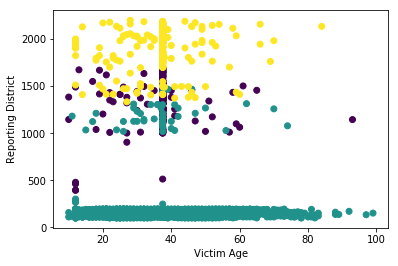

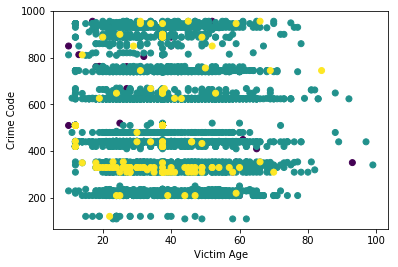

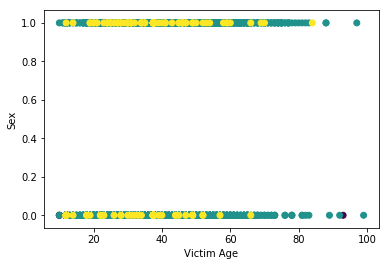

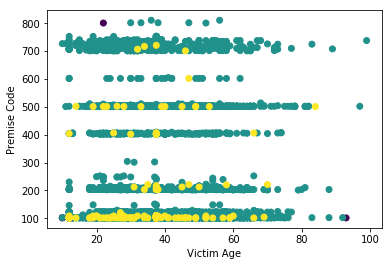

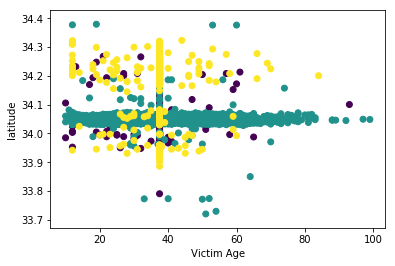

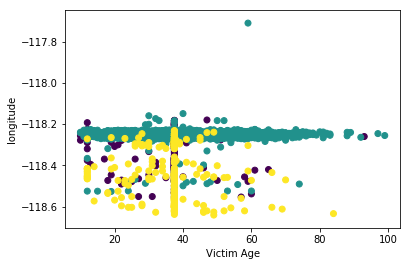

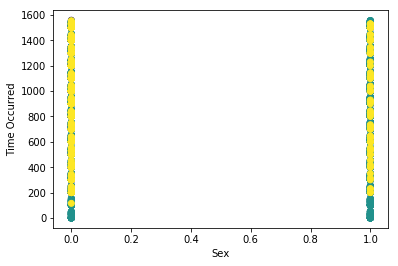

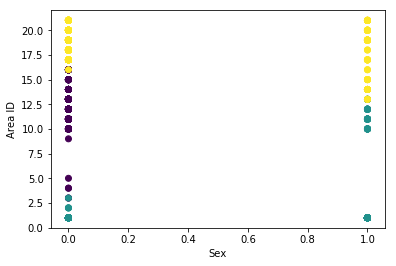

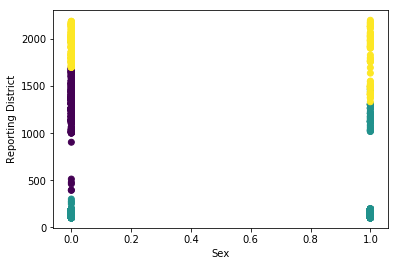

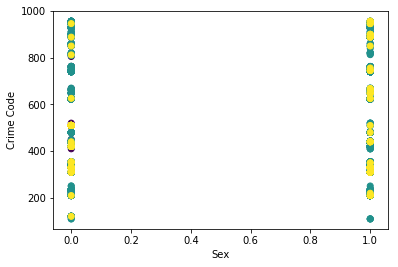

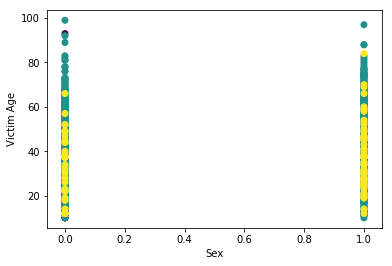

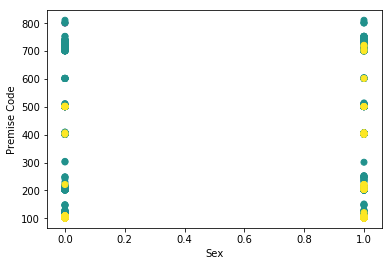

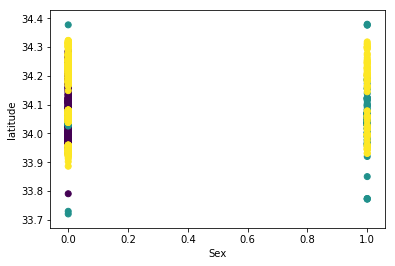

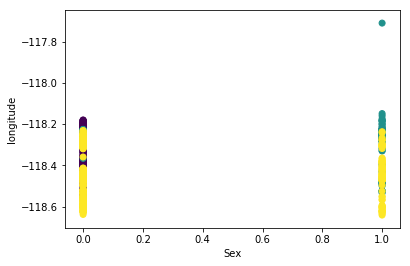

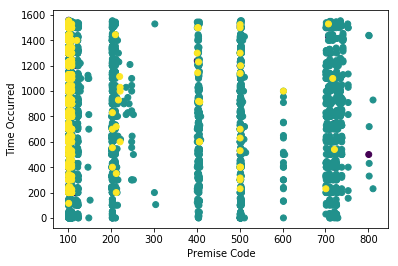

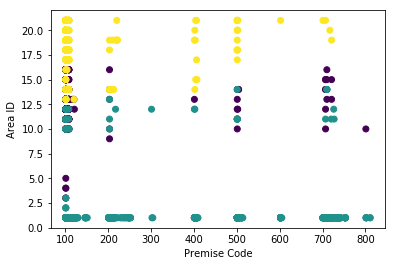

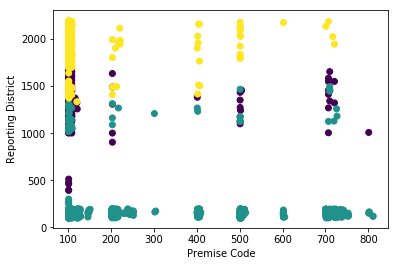

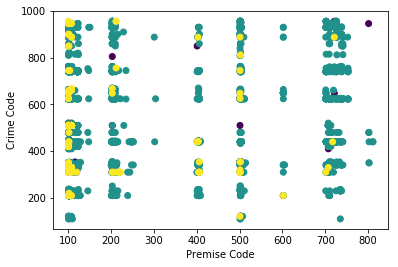

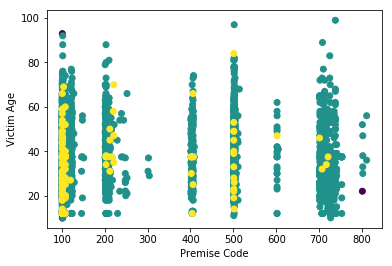

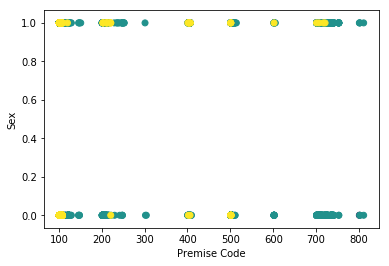

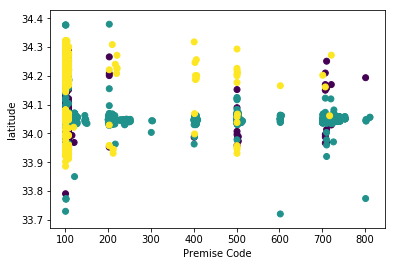

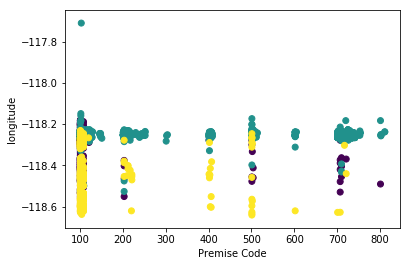

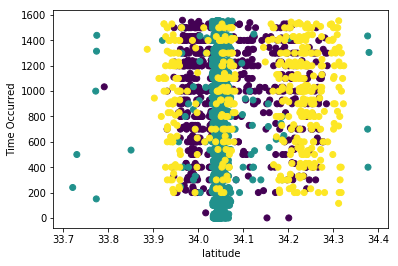

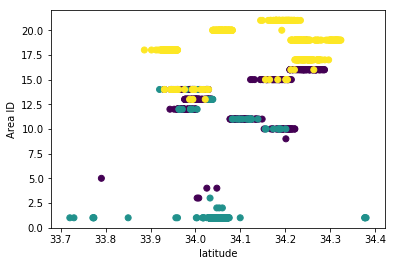

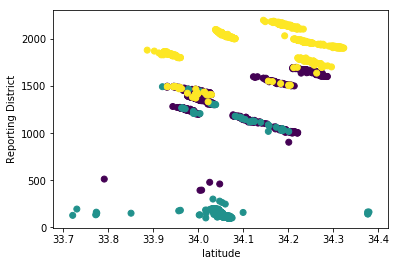

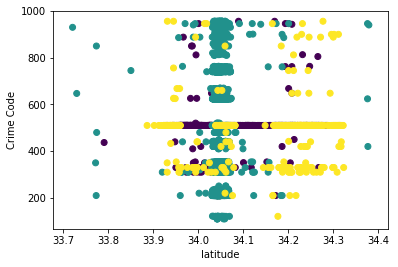

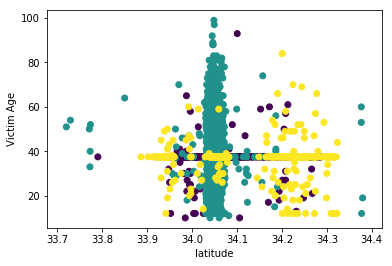

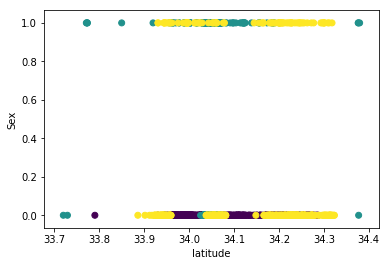

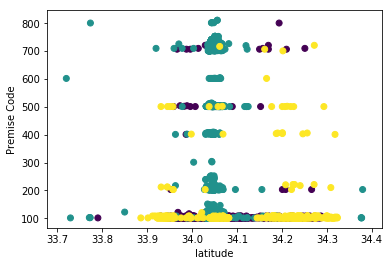

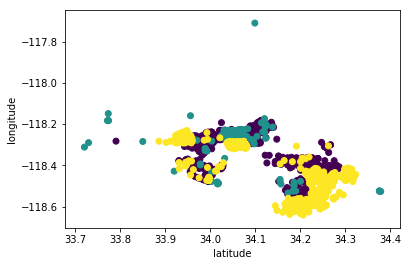

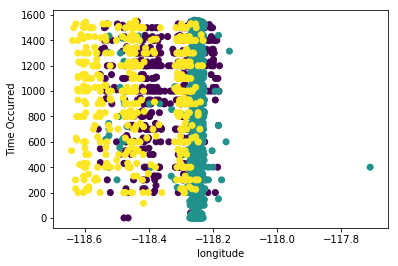

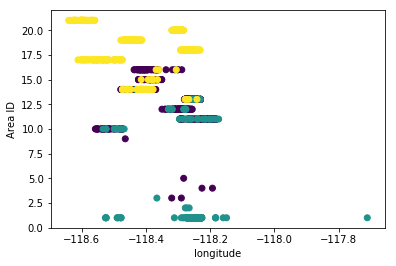

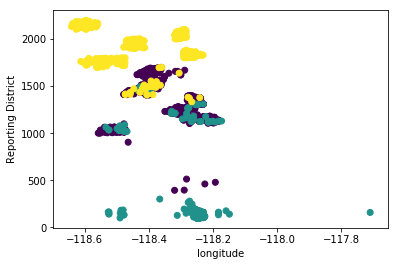

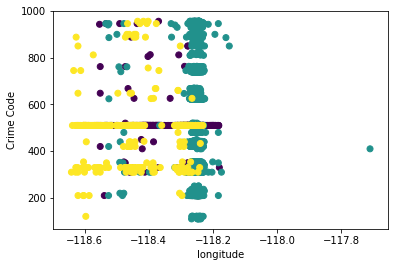

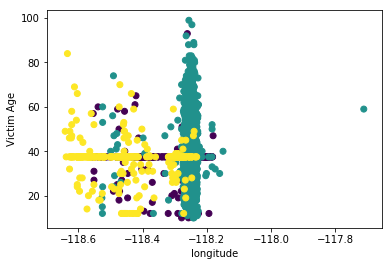

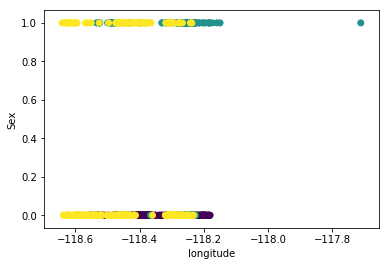

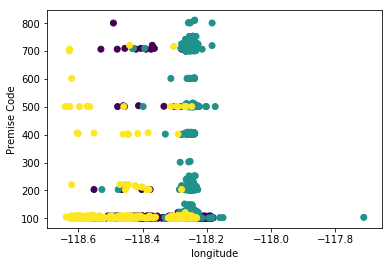

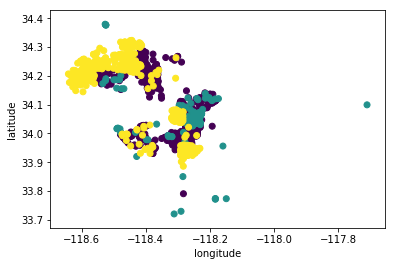

In [177]:
i = 0
j = 1
for col in cols:
    for col2 in cols:
        if (i < j and col != col2):
            plt.scatter(niceDisplay[col],niceDisplay[col2],c = niceDisplay['Cluster'])
            plt.xlabel(col)
            plt.ylabel(col2)
            plt.show()
        j+=1
    i+=1

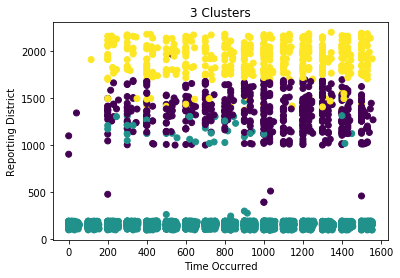

In [184]:
plt.scatter(niceDisplay['Time Occurred'],niceDisplay["Reporting District"],c = niceDisplay['Cluster'])
plt.title('3 Clusters')
plt.xlabel('Time Occurred')
plt.ylabel("Reporting District")
plt.show()

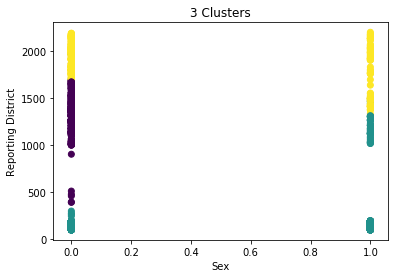

In [185]:
plt.scatter(niceDisplay['Sex'],niceDisplay["Reporting District"],c = niceDisplay['Cluster'])
plt.title('3 Clusters')
plt.xlabel('Sex')
plt.ylabel("Reporting District")
plt.show()

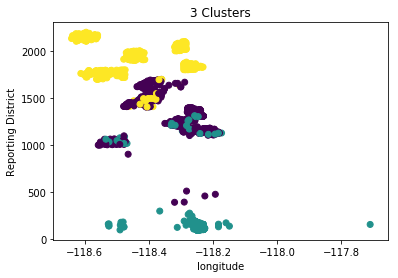

In [186]:
plt.scatter(niceDisplay['longitude'],niceDisplay["Reporting District"],c = niceDisplay['Cluster'])
plt.title('3 Clusters')
plt.xlabel('longitude')
plt.ylabel("Reporting District")
plt.show()

In [178]:
niceDisplay = pd.merge_asof(niceDisplay.sort_values(by=["Crime Code"]), crimeCodes.sort_values(by=["Crime Code"]), on=['Crime Code'])

In [45]:
crimeCodes.head()   

,Crime Code,Crime Code Description
0,0.107352,INTIMATE PARTNER - SIMPLE ASSAULT
1,-0.013987,VEHICLE - STOLEN
2,-0.013987,VEHICLE - STOLEN
3,-0.013987,VEHICLE - STOLEN
4,0.231829,VANDALISM - MISDEAMEANOR ($399 OR UNDER)


In [46]:
niceDisplay.head()

,Area ID,Cluster,Crime Code,Premise Code,Reporting District,Sex,Time Occurred,Victim Age,latitude,longitude
0,0.371410,0.0,-0.087209,-0.176571,0.360983,0.5086,-0.306978,0.045669,-0.002706,-0.000006
1,0.371410,0.0,0.250658,-0.185203,0.361893,0.5086,-0.306978,-0.085644,-0.002706,0.000018
2,0.514267,0.0,-0.085117,0.188410,0.472448,0.5086,0.225415,-0.257361,0.004162,-0.001167
3,-0.152400,0.0,0.105260,-0.183970,-0.135833,0.5086,-0.165862,-0.146250,-0.000437,0.000202
4,-0.152400,0.0,0.131411,-0.059432,-0.127643,0.5086,0.334459,-0.004836,-0.000507,0.000081


In [51]:
niceDisplay.head()

,Area ID,Cluster,Crime Code,Premise Code,Reporting District,Sex,Time Occurred,Victim Age,latitude,longitude,Crime Code Description
0,0.37141,0.0,-0.087209,-0.176571,0.360983,0.5086,-0.306978,0.045669,-0.002706,-0.000006,THEFT PLAIN - PETTY ($950 & UNDER)
1,0.37141,0.0,-0.087209,-0.176571,0.360983,0.5086,-0.306978,0.045669,-0.002706,-0.000006,THEFT PLAIN - PETTY ($950 & UNDER)
2,0.37141,0.0,-0.087209,-0.176571,0.360983,0.5086,-0.306978,0.045669,-0.002706,-0.000006,THEFT PLAIN - PETTY ($950 & UNDER)
3,0.37141,0.0,-0.087209,-0.176571,0.360983,0.5086,-0.306978,0.045669,-0.002706,-0.000006,THEFT PLAIN - PETTY ($950 & UNDER)
4,0.37141,0.0,-0.087209,-0.176571,0.360983,0.5086,-0.306978,0.045669,-0.002706,-0.000006,THEFT PLAIN - PETTY ($950 & UNDER)


# Clustered Data

In [18]:
#niceDisplay
niceDisplay.set_index('Cluster')

,Area ID,Crime Code,Premise Code,Reporting District,Sex,Time Occurred,Victim Age,latitude,longitude,Crime Code Description
Cluster,,,,,,,,,,
0.0,0.371410,-0.087209,-0.176571,0.360983,0.5086,-0.306978,4.566910e-02,-0.002706,-0.000006,THEFT PLAIN - PETTY ($950 & UNDER)
0.0,0.371410,-0.087209,-0.176571,0.360983,0.5086,-0.306978,4.566910e-02,-0.002706,-0.000006,THEFT PLAIN - PETTY ($950 & UNDER)
0.0,0.371410,-0.087209,-0.176571,0.360983,0.5086,-0.306978,4.566910e-02,-0.002706,-0.000006,THEFT PLAIN - PETTY ($950 & UNDER)
0.0,0.371410,-0.087209,-0.176571,0.360983,0.5086,-0.306978,4.566910e-02,-0.002706,-0.000006,THEFT PLAIN - PETTY ($950 & UNDER)
0.0,0.371410,-0.087209,-0.176571,0.360983,0.5086,-0.306978,4.566910e-02,-0.002706,-0.000006,THEFT PLAIN - PETTY ($950 & UNDER)
0.0,0.371410,-0.087209,-0.176571,0.360983,0.5086,-0.306978,4.566910e-02,-0.002706,-0.000006,THEFT PLAIN - PETTY ($950 & UNDER)
0.0,0.371410,-0.087209,-0.176571,0.360983,0.5086,-0.306978,4.566910e-02,-0.002706,-0.000006,THEFT PLAIN - PETTY ($950 & UNDER)
0.0,0.371410,-0.087209,-0.176571,0.360983,0.5086,-0.306978,4.566910e-02,-0.002706,-0.000006,THEFT PLAIN - PETTY ($950 & UNDER)
0.0,0.371410,-0.087209,-0.176571,0.360983,0.5086,-0.306978,4.566910e-02,-0.002706,-0.000006,THEFT PLAIN - PETTY ($950 & UNDER)


# Displays Top 5 Crimes in Cluster 0

In [19]:
niceDisplay.loc[niceDisplay['Cluster'] == 0].groupby(['Crime Code Description']).count().sort_values(by=['Crime Code'], ascending=False).head()

,Area ID,Cluster,Crime Code,Premise Code,Reporting District,Sex,Time Occurred,Victim Age,latitude,longitude
Crime Code Description,,,,,,,,,,
BATTERY - SIMPLE ASSAULT,183696,183696,183696,183696,183696,183696,183696,183696,183696,183696
BURGLARY FROM VEHICLE,59549,59549,59549,59549,59549,59549,59549,59549,59549,59549
THEFT PLAIN - PETTY ($950 & UNDER),49950,49950,49950,49950,49950,49950,49950,49950,49950,49950
ROBBERY,27872,27872,27872,27872,27872,27872,27872,27872,27872,27872
VANDALISM - MISDEAMEANOR ($399 OR UNDER),25080,25080,25080,25080,25080,25080,25080,25080,25080,25080


In [22]:
niceDisplay.groupby(['Cluster']).count()

,Area ID,Crime Code,Premise Code,Reporting District,Sex,Time Occurred,Victim Age,latitude,longitude,Crime Code Description
Cluster,,,,,,,,,,
0.0,424493,424493,423475,424493,424493,424493,424493,424493,424493,424493
1.0,240968,240968,240968,240968,240968,240968,240968,240968,240968,240968
2.0,1443231,1443231,1443231,1443231,1443231,1443231,1443231,1443231,1443231,1443231


In [25]:
tester =niceDisplay.drop_duplicates()

In [27]:
tester.groupby(['Cluster']).count()

,Area ID,Crime Code,Premise Code,Reporting District,Sex,Time Occurred,Victim Age,latitude,longitude,Crime Code Description
Cluster,,,,,,,,,,
0.0,1578,1578,1576,1578,1578,1578,1578,1578,1578,1578
1.0,870,870,870,870,870,870,870,870,870,870
2.0,2535,2535,2535,2535,2535,2535,2535,2535,2535,2535


4983

In [30]:
len(niceDisplay[niceDisplay['Cluster'] == 0]),len(niceDisplay[niceDisplay['Cluster'] == 1]),len(niceDisplay[niceDisplay['Cluster'] == 2])

(424493, 240968, 1443231)